<a href="https://colab.research.google.com/github/andcetera/deep-learning-challenge/blob/main/AlphabetSoupCharity_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 KB 4.0 MB/s eta 0:00:00


In [3]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks
import keras_tuner as kt

# Connect to Google Drive to access dataset file
from google.colab import drive
drive.mount('/content/drive')

#  Import and read the charity_data.csv.
import pandas as pd 
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/charity_data.csv")
df.head()

Mounted at /content/drive


,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [4]:
# Drop the non-beneficial ID columns: 'EIN' and 'NAME'
apps = df.drop(columns=['EIN', 'NAME'])

# Checking number of unique values in remaining columns
apps.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [5]:
app_type = apps['APPLICATION_TYPE'].value_counts()

# Choose a different cutoff value and create a list of application types to be replaced
application_types_to_replace = [app for app in app_type.index if app_type[app] < 10]

# Replace in dataframe
for app in application_types_to_replace:
    apps['APPLICATION_TYPE'] = apps['APPLICATION_TYPE'].replace(app,"Other")

# Check to make sure binning was successful
apps['APPLICATION_TYPE'].value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
T9         156
T13         66
T12         27
T2          16
Other       11
Name: APPLICATION_TYPE, dtype: int64

In [6]:
class_types = apps['CLASSIFICATION'].value_counts()

# Choose a different cutoff value and create a list of classifications to be replaced
classifications_to_replace = [cls for cls in class_types.index if class_types[cls] < 100]

# Replace in dataframe
for cls in classifications_to_replace:
    apps['CLASSIFICATION'] = apps['CLASSIFICATION'].replace(cls,"Other")
    
# Check to make sure binning was successful
apps['CLASSIFICATION'].value_counts()

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
Other      669
C1700      287
C4000      194
C5000      116
C1270      114
C2700      104
Name: CLASSIFICATION, dtype: int64

In [7]:
# Convert categorical data to numeric with `pd.get_dummies`
affil = pd.get_dummies(apps['AFFILIATION'], drop_first=True, prefix='AFFIL')
use_case = pd.get_dummies(apps['USE_CASE'], drop_first=True, prefix='USE')
org = pd.get_dummies(apps['ORGANIZATION'], drop_first=True, prefix='ORG')
special = pd.get_dummies(apps['SPECIAL_CONSIDERATIONS'], drop_first=True, prefix='SPEC')
app_type = pd.get_dummies(apps['APPLICATION_TYPE'], drop_first=True, prefix='APP')
class_type = pd.get_dummies(apps['CLASSIFICATION'], drop_first=True, prefix='CLASS')
income = pd.get_dummies(apps['INCOME_AMT'], drop_first=True, prefix='INC')
data = apps[['STATUS', 'ASK_AMT', 'IS_SUCCESSFUL']]
data = pd.concat([data, income, affil, use_case, org, special, app_type, class_type], axis=1)
data.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,INC_1-9999,INC_10000-24999,INC_100000-499999,INC_10M-50M,INC_1M-5M,INC_25000-99999,INC_50M+,...,CLASS_C1270,CLASS_C1700,CLASS_C2000,CLASS_C2100,CLASS_C2700,CLASS_C3000,CLASS_C4000,CLASS_C5000,CLASS_C7000,CLASS_Other
0,1,5000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,108590,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1,5000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,6692,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,142590,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Split the preprocessed data into features and target arrays
y = data['IS_SUCCESSFUL'].values.reshape(-1, 1)
X = data.drop('IS_SUCCESSFUL', axis=1)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)

In [9]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [10]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp:kt.HyperParameters)->tf.keras.Model:
    nn = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh', 'lrelu'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=30,
        max_value=100,
        step=10), activation=activation, input_dim=X_train.shape[1]))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=30,
            max_value=100,
            step=10),
            activation=activation))
    
    # Add the final output layer
    nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn

In [11]:
# Create a tuner with the goal of best accuracy within a short run of 20 epochs
tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

In [43]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

In [44]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'relu',
 'first_units': 100,
 'num_layers': 4,
 'units_0': 70,
 'units_1': 40,
 'units_2': 30,
 'units_3': 30,
 'units_4': 50,
 'units_5': 90,
 'tuner/epochs': 7,
 'tuner/initial_epoch': 3,
 'tuner/bracket': 2,
 'tuner/round': 1,
 'tuner/trial_id': '0027'}

In [45]:
# Get top 3 model hyperparameters and print the values
top_hyper = tuner.get_best_hyperparameters(3)
for param in top_hyper:
  print(param.values)

{'activation': 'relu', 'first_units': 100, 'num_layers': 4, 'units_0': 70, 'units_1': 40, 'units_2': 30, 'units_3': 30, 'units_4': 50, 'units_5': 90, 'tuner/epochs': 7, 'tuner/initial_epoch': 3, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0027'}
{'activation': 'relu', 'first_units': 50, 'num_layers': 1, 'units_0': 30, 'units_1': 30, 'units_2': 90, 'units_3': 30, 'units_4': 60, 'units_5': 90, 'tuner/epochs': 7, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
{'activation': 'relu', 'first_units': 50, 'num_layers': 3, 'units_0': 80, 'units_1': 70, 'units_2': 70, 'units_3': 100, 'units_4': 50, 'units_5': 80, 'tuner/epochs': 7, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}


In [46]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5550 - accuracy: 0.7319 - 978ms/epoch - 4ms/step
Loss: 0.5549536943435669, Accuracy: 0.7318950295448303


In [12]:
# Define the number of features for the input layer, and max nodes for each hidden layer
input = X_train.shape[1]
layer_1 = 100
layer_2 = 70
layer_3 = 40
layer_4 = 30
layer_5 = 30
layer_6 = 50
layer_7 = 90

model = tf.keras.models.Sequential()

# First hidden layer
model.add(tf.keras.layers.Dense(units=layer_1, activation='relu', input_dim=input))

# additional hidden layers
model.add(tf.keras.layers.Dense(units=layer_2, activation='relu'))

model.add(tf.keras.layers.Dense(units=layer_3, activation='relu'))

model.add(tf.keras.layers.Dense(units=layer_4, activation='relu'))

model.add(tf.keras.layers.Dense(units=layer_5, activation='relu'))

model.add(tf.keras.layers.Dense(units=layer_6, activation='relu'))

model.add(tf.keras.layers.Dense(units=layer_7, activation='relu'))

# Output layer
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               4700      
                                                                 
 dense_4 (Dense)             (None, 70)                7070      
                                                                 
 dense_5 (Dense)             (None, 40)                2840      
                                                                 
 dense_6 (Dense)             (None, 30)                1230      
                                                                 
 dense_7 (Dense)             (None, 30)                930       
                                                                 
 dense_8 (Dense)             (None, 50)                1550      
                                                                 
 dense_9 (Dense)             (None, 90)               

In [13]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create callback to save weights every 5 epochs
cb = tf.keras.callbacks.ModelCheckpoint(filepath='weights_{epoch:03d}.h5', save_weights_only=True, period=5)

# Create callback to stop if our model doesn't improve loss within 50 epochs & restore to best previous weights
es = callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=50, restore_best_weights=True, verbose=1)

In [14]:
# Train the model
fit_model = model.fit(X_train_scaled, y_train, epochs=500, callbacks=[cb, es])

Epoch 1/500
804/804 [==============================] - 4s 3ms/step - loss: 0.5742 - accuracy: 0.7163
Epoch 2/500
804/804 [==============================] - 2s 3ms/step - loss: 0.5559 - accuracy: 0.7291
Epoch 3/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5523 - accuracy: 0.7301
Epoch 4/500
804/804 [==============================] - 2s 3ms/step - loss: 0.5501 - accuracy: 0.7311
Epoch 5/500
804/804 [==============================] - 2s 3ms/step - loss: 0.5482 - accuracy: 0.7323
Epoch 6/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5477 - accuracy: 0.7336
Epoch 7/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5462 - accuracy: 0.7336
Epoch 8/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5460 - accuracy: 0.7329
Epoch 9/500
804/804 [==============================] - 3s 3ms/step - loss: 0.5445 - accuracy: 0.7351
Epoch 10/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5448 - accura

In [15]:
# Evaluate the model using the test data
model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5929 - accuracy: 0.7273 - 646ms/epoch - 2ms/step
Loss: 0.5928720235824585, Accuracy: 0.7273469567298889


<Axes: title={'center': 'Training Accuracy'}>

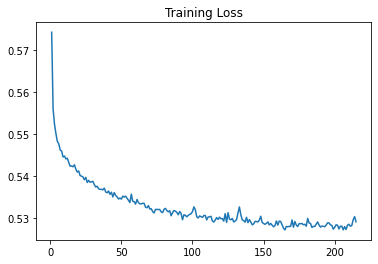

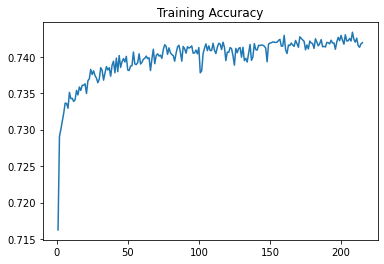

In [16]:
# Create a DataFrame containing training history
hist = pd.DataFrame(fit_model.history)
hist.index += 1

# Plot the training loss & accuracy
hist.plot(y="loss", title="Training Loss", legend=False)
hist.plot(y='accuracy', title="Training Accuracy", legend=False)

In [ ]:
# Define the number of features for the input layer, and max nodes for each hidden layer
input = X_train.shape[1]
layer_1 = 50
layer_2 = 50
layer_3 = 90
layer_4 = 80
layer_5 = 70
layer_6 = 90

model2 = tf.keras.models.Sequential()

# First hidden layer
model2.add(tf.keras.layers.Dense(units=layer_1, activation='relu', input_dim=input))

# additional hidden layers
model2.add(tf.keras.layers.Dense(units=layer_2, activation='relu'))

model2.add(tf.keras.layers.Dense(units=layer_3, activation='relu'))

model2.add(tf.keras.layers.Dense(units=layer_4, activation='relu'))

model2.add(tf.keras.layers.Dense(units=layer_5, activation='relu'))

model2.add(tf.keras.layers.Dense(units=layer_6, activation='relu'))

# Output layer
model2.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                2350      
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 90)                4590      
                                                                 
 dense_3 (Dense)             (None, 80)                7280      
                                                                 
 dense_4 (Dense)             (None, 70)                5670      
                                                                 
 dense_5 (Dense)             (None, 90)                6390      
                                                                 
 dense_6 (Dense)             (None, 1)                 9

In [ ]:
# Compile the model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create callback to save weights every 5 epochs
cb = tf.keras.callbacks.ModelCheckpoint(filepath='weights_{epoch:03d}.h5', save_weights_only=True, period=5)

# Create callback to stop if our model doesn't improve loss within 50 epochs & restore to best previous weights
es = callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=50, restore_best_weights=True, verbose=1)

In [ ]:
# Train the model
fit_model2 = model2.fit(X_train_scaled, y_train, epochs=500, callbacks=[cb, es])

Epoch 1/500
804/804 [==============================] - 5s 3ms/step - loss: 0.5418 - accuracy: 0.7352
Epoch 2/500
804/804 [==============================] - 2s 3ms/step - loss: 0.5409 - accuracy: 0.7354
Epoch 3/500
804/804 [==============================] - 2s 3ms/step - loss: 0.5407 - accuracy: 0.7359
Epoch 4/500
804/804 [==============================] - 2s 3ms/step - loss: 0.5396 - accuracy: 0.7362
Epoch 5/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5392 - accuracy: 0.7362
Epoch 6/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5396 - accuracy: 0.7364
Epoch 7/500
804/804 [==============================] - 2s 3ms/step - loss: 0.5394 - accuracy: 0.7357
Epoch 8/500
804/804 [==============================] - 2s 3ms/step - loss: 0.5394 - accuracy: 0.7367
Epoch 9/500
804/804 [==============================] - 2s 3ms/step - loss: 0.5393 - accuracy: 0.7363
Epoch 10/500
804/804 [==============================] - 3s 3ms/step - loss: 0.5384 - accura

In [ ]:
# Evaluate the model using the test data
model_loss, model_accuracy = model2.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5795 - accuracy: 0.7280 - 608ms/epoch - 2ms/step
Loss: 0.5795153379440308, Accuracy: 0.7280466556549072


<Axes: title={'center': 'Training Accuracy'}>

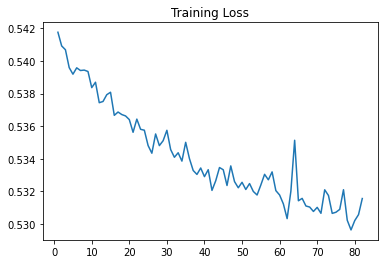

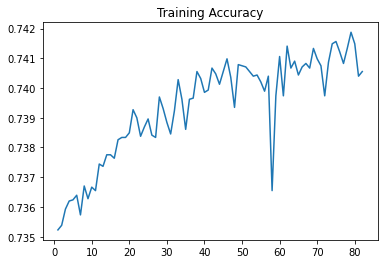

In [ ]:
# Create a DataFrame containing training history
hist = pd.DataFrame(fit_model2.history)
hist.index += 1

# Plot the training loss & accuracy
hist.plot(y="loss", title="Training Loss", legend=False)
hist.plot(y='accuracy', title="Training Accuracy", legend=False)

In [ ]:
# Export our model to HDF5 file
model2.save('AlphabetSoupCharity_Optimization.h5')

In [ ]:
# Random guess =
1 - sum(y)/len(y)

array([0.46759381])